# Visualize precomputed explanations

In this notebook we load explanations that were computed through `explain_all.py` and visualize some of them and do some aggregations.

#### 1. Imports and paths

In [50]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from dianna import visualization
from dianna.utils.tokenizers import SpacyTokenizer
from train_inlegalbert_xgboost import class_names
from xai_file_convert import convert_json_explanations
import warnings
warnings.filterwarnings('ignore')
from transformers import logging
logging.set_verbosity_error()

#### Convert json results to two csv files (one for each explanation class)

0 - constitutive

1 - regulatory

In [51]:
convert_json_explanations(Path('./results_1000.json'), Path('./class_0_explanations.csv'), Path('./class_1_explanations.csv'))

Loaded 1341 existing explanations from results_1000.json.


#### Import model file

In [52]:
model_path = Path('inlegal_bert_xgboost_classifier.json')

#### Some test data

In [53]:
constitutive_statement_0 = "The purchase, import or transport from Syria of crude oil and petroleum products shall be prohibited."
constitutive_statement_1 = "This Decision shall enter into force on the twentieth day following that of its publication in the Official Journal of the European Union."
regulatory_statement_0 = "Where observations are submitted, or where substantial new evidence is presented, the Council shall review its decision and inform the person or entity concerned accordingly."
regulatory_statement_1 = "The relevant Member State shall inform the other Member States of any authorisation granted under this Article."
regulatory_statement_2 = "Member States shall cooperate, in accordance with their national legislation, with inspections and disposals undertaken pursuant to paragraphs 1 and 2."

#### Load classifier from model

In [54]:
from classify_text_with_inlegal_bert_xgboost import classify_texts


class StatementClassifier:
    def __init__(self):
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        probs = classify_texts(sentences, model_path, return_proba=True)

        return np.transpose([(probs[:, 0]), (1 - probs[:, 0])])
            

In [55]:
# define model runner. max_filter_size is a property of the model
model_runner = StatementClassifier()

#### Test the model

In [56]:
prediction = model_runner([constitutive_statement_0,constitutive_statement_1, regulatory_statement_0, regulatory_statement_1,regulatory_statement_2])
[class_names[m] for m in np.argmax(prediction, axis=1)]

Creating features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.10it/s]


['constitutive', 'constitutive', 'regulatory', 'regulatory', 'regulatory']

#### Load precomputed explanation data

In [57]:
p = Path('./results_1000.json')
with open(p, 'r') as f:
    results = json.load(f)

tokenizer = SpacyTokenizer(name='en_core_web_sm')

#### Investigate a single statement: classify

In [58]:
statement_no = 0
statement = list(results.keys())[statement_no]
print(statement)
prediction = model_runner([statement])[0]
print(prediction)

This Decision shall apply until 13 April 2014.


Creating features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]

[0.99885535 0.00114465]


#### Investigate a single statement: explain

   constitutive  regulatory
0      0.998855    0.001145
class label *constitutive* was predicted for this sentence
      token    weight
0     until  0.008728
1      This  0.008691
2     April  0.004082
3         .  0.003489
4        13  0.003190
5  Decision  0.002734
6      2014  0.002730
7     shall  0.002643
8     apply  0.001684


(<Figure size 1000x100 with 2 Axes>, <Axes: >)

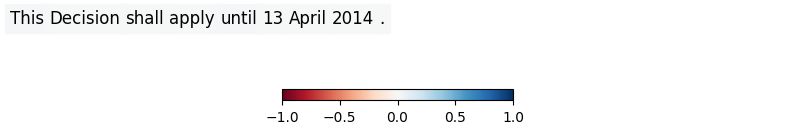

In [59]:
explanation_relevance = results[statement]
print(pd.DataFrame([prediction,], columns=class_names))
top_class = np.argmax(prediction)
print(f'class label *{class_names[top_class]}* was predicted for this sentence')
label_of_interest = top_class
print(pd.DataFrame(explanation_relevance[0], columns=['token','start','weight']).drop(['start'], axis=1))
visualization.highlight_text(explanation_relevance[label_of_interest], tokenizer.tokenize(statement))

### Add model and ground truth classification results to explanation analysis data

In [78]:
## load explanation data
# df = pd.read_csv('class_0_explanations.csv')
df = pd.read_csv('class_1_explanations.csv')
df.head()

,Unnamed: 0,word,sentence,start_index,attribution
0,0,until,This Decision shall apply until 13 April 2014.,4,-0.008728
1,1,This,This Decision shall apply until 13 April 2014.,0,-0.008691
2,2,April,This Decision shall apply until 13 April 2014.,6,-0.004082
3,3,.,This Decision shall apply until 13 April 2014.,8,-0.003489
4,4,13,This Decision shall apply until 13 April 2014.,5,-0.003190


In [61]:
# get model results
model_results_dict = {}

# first try to load from file
import json
f = open('model_classifications.json')
model_results_dict = json.load(f)

# otherwise generate them
if model_results_dict is None or len(model_results_dict) == 0:
    for i in range(0, len(list(results.keys()))):
        statement = list(results.keys())[i]
        prediction = model_runner([statement])[0]
        top_class = np.argmax(prediction)
        model_results_dict[statement] = class_names[top_class]
    
model_results = list(model_results_dict.values())

Creating features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.41it/s]


In [62]:
# get ground truth results
gt = pd.read_csv('complete_training_data_7200_cases.csv')
ground_truth_results_dict = {}

for i in range(0, len(list(results.keys()))):
    statement = list(results.keys())[i]
    res = gt.loc[gt['sent'] == statement, 'Regulatory (1) Constitutive (0)'].tolist()[0]
    if str(res) == '0':
        ground_truth_results_dict[statement] = "constitutive"
    else:
        ground_truth_results_dict[statement] = "regulatory"

ground_truth_results = list(ground_truth_results_dict.values())

In [77]:
# add model and ground truth results to explanation data
gtr = []
mr = []
for index, row in df.iterrows():
    gtr.append(ground_truth_results_dict[row['sentence']])
    mr.append(model_results_dict[row['sentence']])

df['model'] = mr
df['ground_truth'] = gtr

with open("model_classifications.json", "w") as outfile: 
    json.dump(model_results_dict, outfile)

with open("ground_truth_classifications.json", "w") as outfile: 
    json.dump(ground_truth_results_dict, outfile)

In [66]:
# save augmented data to file
df.to_csv('results_with_classifications_0.csv', index=False)

### Explanations of a batch of statements

Creating features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 24.37it/s]


Explanations for class constitutive
Explanations for class regulatory


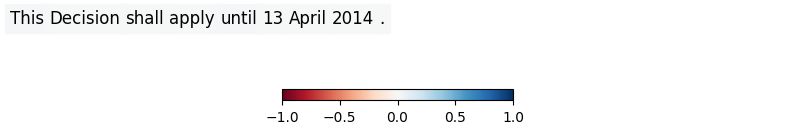

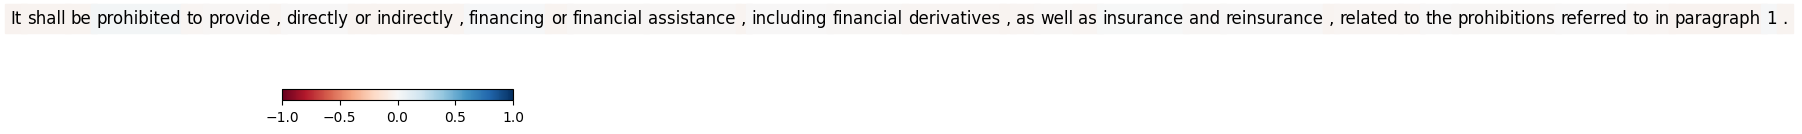

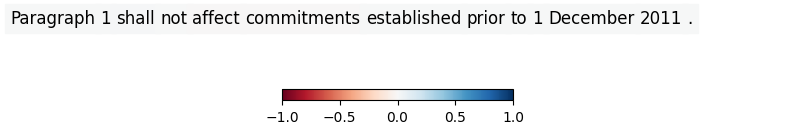

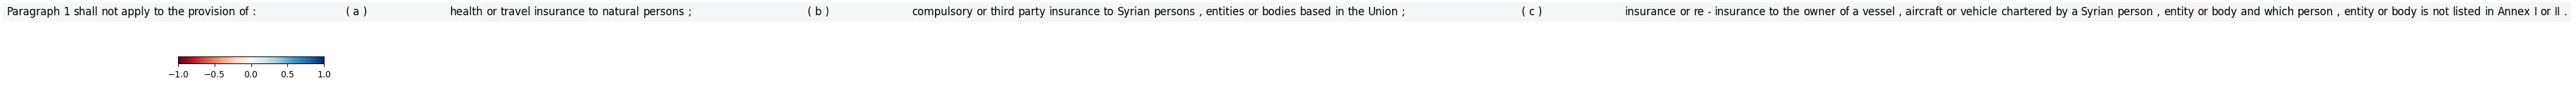

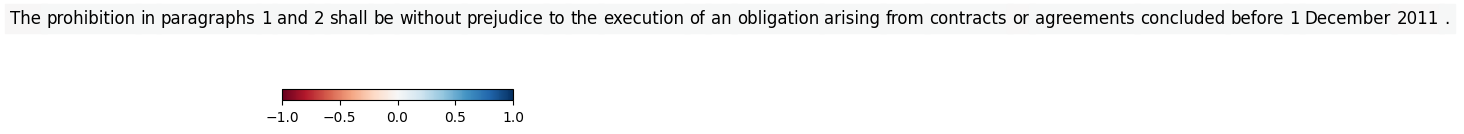

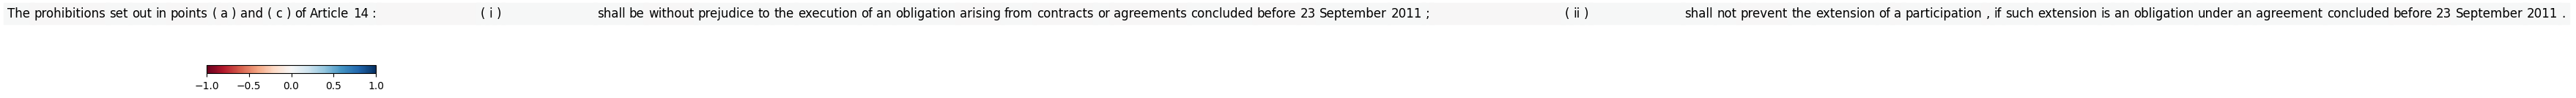

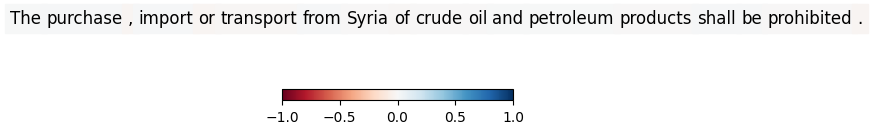

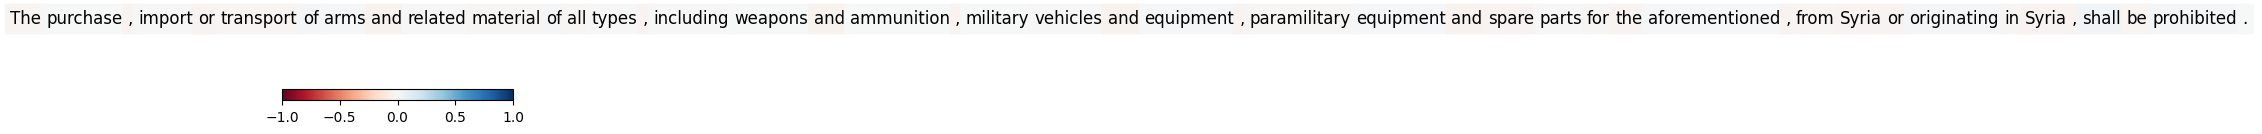

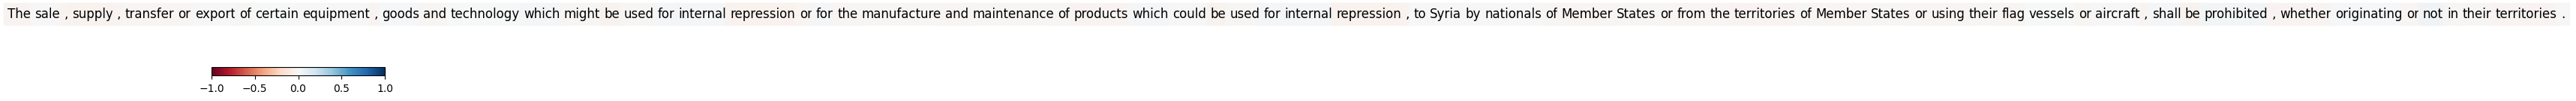

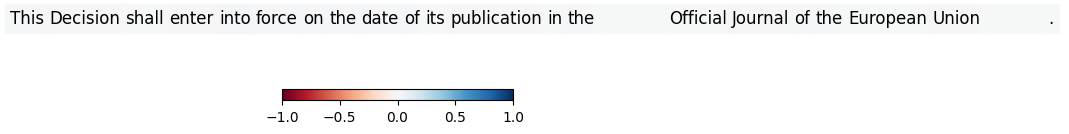

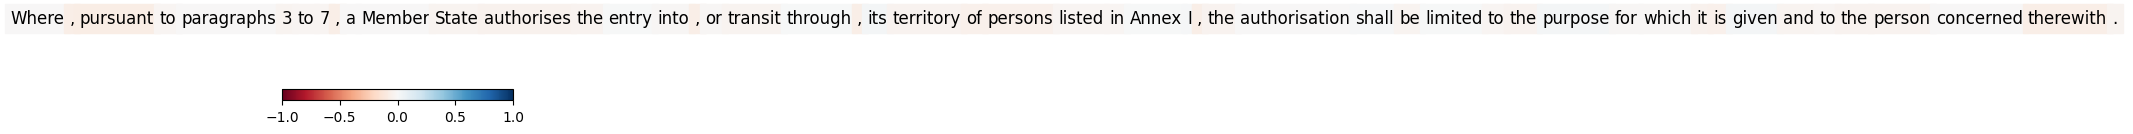

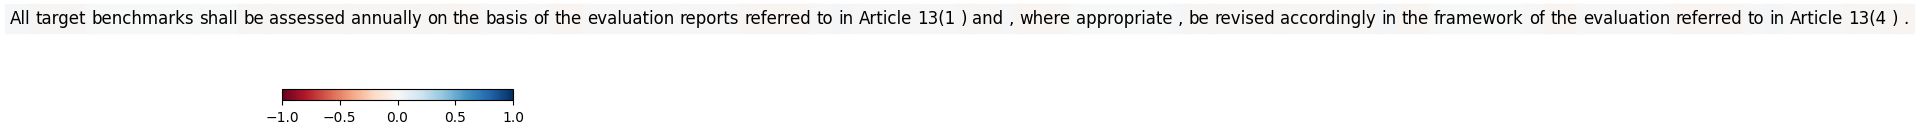

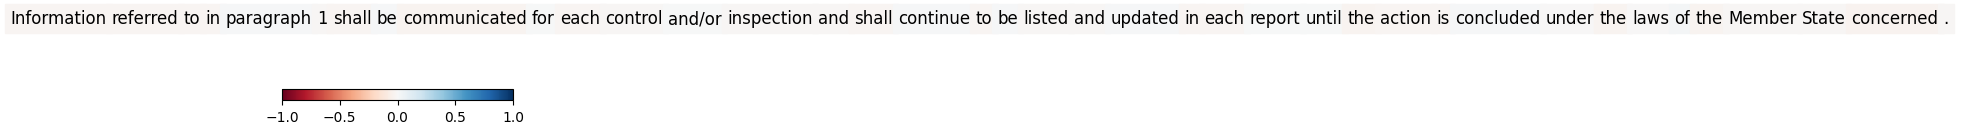

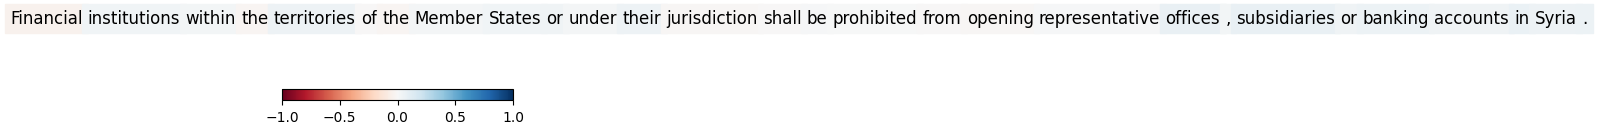

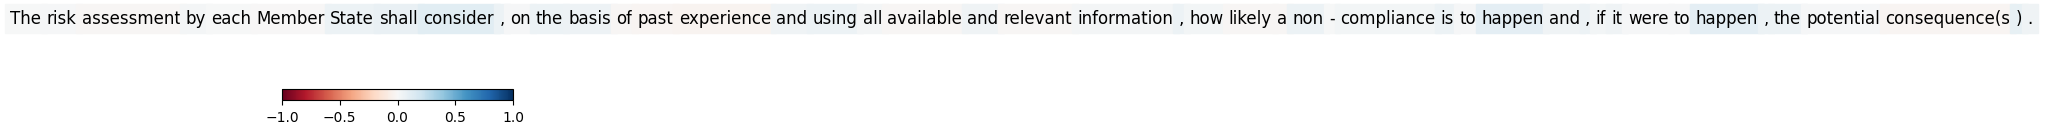

In [67]:
statements = list(results.keys())[:15]
predictions = model_runner(statements)

for label_of_interest in range(len(class_names)):
    print(f'Explanations for class {class_names[label_of_interest]}')
    for statement, prediction in zip(statements, predictions):
        if np.argmax(prediction) == label_of_interest:
            visualization.highlight_text(results[statement][label_of_interest], tokenizer.tokenize(statement))

### Aggregated results

In [68]:
label_of_interest = 0
statement_infos = [statement_info[label_of_interest] for _statement, statement_info in results.items()]
token_infos = pd.DataFrame([    x    for xs in statement_infos    for x in xs], columns=['token', 'start', 'weight']).drop('start', axis=1)

token_infos.groupby('token').mean()

,weight
token,
,-0.005380
,0.001123
,0.000726
,0.000161
,-0.000723
...,...
‘,-0.000024
’,0.000642
’s,0.000481


### Analyse results (overall)

In [69]:
expl_df = pd.read_csv('results_with_classifications_0.csv')

In [70]:
# model and ground truth disagreement (num of rows)
disagreement = expl_df.loc[~(expl_df['model'] == expl_df['ground_truth'])]
print(len(disagreement))

10817


In [71]:
expl_df.head()

,Unnamed: 0,word,sentence,start_index,attribution,model,ground_truth
0,0,until,This Decision shall apply until 13 April 2014.,4,0.008728,constitutive,constitutive
1,1,This,This Decision shall apply until 13 April 2014.,0,0.008691,constitutive,constitutive
2,2,April,This Decision shall apply until 13 April 2014.,6,0.004082,constitutive,constitutive
3,3,.,This Decision shall apply until 13 April 2014.,8,0.003489,constitutive,constitutive
4,4,13,This Decision shall apply until 13 April 2014.,5,0.003190,constitutive,constitutive


### Top n words indicating constitutive or regulatory statements

In [73]:
m = expl_df.sort_values(['model', 'attribution'],ascending=False)
g = expl_df.sort_values(['ground_truth','attribution'],ascending=False)

mean_agg_m = m.groupby(['model', 'word'], as_index=False).agg({'attribution': 'mean'})
mean_agg_g = g.groupby(['ground_truth', 'word'], as_index=False).agg({'attribution': 'mean'})

mean_agg_m = mean_agg_m.sort_values(['model','attribution'],ascending=False)
mean_agg_g = mean_agg_g.sort_values(['ground_truth','attribution'],ascending=False)

In [74]:
mean_agg_m

,model,word,attribution
5538,regulatory,evaporation,0.101364
5474,regulatory,emblem,0.069361
5313,regulatory,declassified,0.060414
5731,regulatory,grants,0.059334
5934,regulatory,investigators,0.058484
...,...,...,...
1699,constitutive,consensus,-0.086982
3610,constitutive,strategic,-0.090943
3260,constitutive,rectify,-0.095571
1490,constitutive,bring,-0.105090


In [76]:
mean_agg_g

,ground_truth,word,attribution
5293,regulatory,evaporation,0.101364
5218,regulatory,emblem,0.069361
5031,regulatory,declassified,0.060414
4276,regulatory,Technical,0.059467
5744,regulatory,investigators,0.058484
...,...,...,...
2463,constitutive,offices,-0.089187
3097,constitutive,strategic,-0.090943
1800,constitutive,exchanges,-0.101909
1246,constitutive,bring,-0.105090


In [75]:
# save model and ground truth aggregated attribution
mean_agg_m.to_csv('mean_agg_m_0.csv', index=False)
mean_agg_g.to_csv('mean_agg_g_0.csv', index=False)